# <center style='color:blue'>Artificial Neural Network (ANN) - Example using USPS dataset</center>

## 1. Import the libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt

## 2. Define the device

In [2]:
print('PyTorch version:', torch.__version__, '\n')
print('GPU name:', torch.cuda.get_device_name(), '\n')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device is:', device, '\n')
print('Total number of GPUs:', torch.cuda.device_count())

PyTorch version: 2.0.1+cu117 

GPU name: NVIDIA RTX A5000 

Device is: cuda 

Total number of GPUs: 1


## 3. Load `USPS dataset`

In [3]:
training_dataset = datasets.USPS('./data_src', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.USPS('./data_src', train=False, download=True, transform=transforms.ToTensor())

100%|███████████████████████████████████████████████| 6579383/6579383 [00:00<00:00, 18655555.80it/s]


100%|████████████████████████████████████████████████| 1831726/1831726 [00:00<00:00, 6362085.01it/s]


In [4]:
# check the length of training and test datasets

print('Length of the training dataset:', len(training_dataset))
print('Length of the test dataset:', len(test_dataset))

Length of the training dataset: 7291
Length of the test dataset: 2007


##### In total, there are `7291 samples (images)` in the `training set` and `2007 samples (images)` in the `test set`.

In [5]:
# check the shape of training and test datasets

print('Shape of the training dataset:', training_dataset.data.shape)
print('Shape of the test dataset:', test_dataset.data.shape)

Shape of the training dataset: (7291, 16, 16)
Shape of the test dataset: (2007, 16, 16)


Shape: (total images, height, width)

##### The `spatial dimension` of the `grayscale images` in the `USPS dataset` is `16x16` pixels.

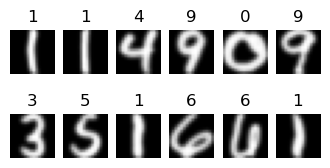

In [6]:
# show 12 randomly selected samples from the training dataset

fig, axis = plt.subplots(nrows=2, ncols=6, figsize=(4, 2))

for ax, _ in zip(axis.ravel(), range(12)):
    inx = np.random.randint(len(training_dataset))
    ax.imshow(training_dataset.data[inx], cmap='Greys_r')
    ax.set_title(training_dataset.targets[inx], fontsize=12)
    ax.axis(False);

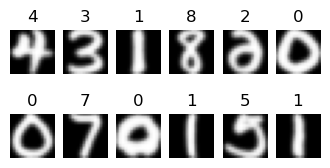

In [7]:
# show 12 randomly selected samples from the test dataset

fig, axis = plt.subplots(nrows=2, ncols=6, figsize=(4, 2))

for ax, _ in zip(axis.ravel(), range(12)):
    inx = np.random.randint(len(test_dataset))
    ax.imshow(test_dataset.data[inx], cmap='Greys_r')
    ax.set_title(test_dataset.targets[inx], fontsize=12)
    ax.axis(False);

## 4. Define dataloaders

In [8]:
training_dataloader = DataLoader(training_dataset, batch_size=32, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=True)

In [9]:
# check the length of training and test dataloaders

print('Length of the training dataloader:', len(training_dataloader))
print('Length of the test dataloader:', len(test_dataloader))

Length of the training dataloader: 227
Length of the test dataloader: 62


Since, neither 7291 nor 2007 is divisible by 32; the last batch will not have 32 images in it and hence I dropped it. 227 and 62 are showing the number of batches in training and test dataloaders, respectively.

##### Dataloader converts a dataset into an iterable.

## 5. Define the network architecture

In [10]:
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        
        self._ann = nn.Sequential()
        self._ann.add_module('linear1', nn.Linear(in_features=16*16, out_features=128))
        self._ann.add_module('relu1', nn.ReLU(inplace=True))
        self._ann.add_module('linear2', nn.Linear(in_features=128, out_features=64))
        self._ann.add_module('relu2', nn.ReLU(inplace=True))
        self._ann.add_module('linear3', nn.Linear(in_features=64, out_features=10))
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self._ann(x)
        return x

## 6. Visualize the model architecture

In [11]:
model = ANN().to(device)
summary(model, input_size=(32, 1, 16, 16))

Layer (type:depth-idx)                   Output Shape              Param #
ANN                                      [32, 10]                  --
├─Sequential: 1-1                        [32, 10]                  --
│    └─Linear: 2-1                       [32, 128]                 32,896
│    └─ReLU: 2-2                         [32, 128]                 --
│    └─Linear: 2-3                       [32, 64]                  8,256
│    └─ReLU: 2-4                         [32, 64]                  --
│    └─Linear: 2-5                       [32, 10]                  650
Total params: 41,802
Trainable params: 41,802
Non-trainable params: 0
Total mult-adds (M): 1.34
Input size (MB): 0.03
Forward/backward pass size (MB): 0.05
Params size (MB): 0.17
Estimated Total Size (MB): 0.25

## 7. Define the training batch

In [12]:
def training_batch(data, labels, model, criterion, optimizer):
    model.train()
    data = data.to(device)
    labels = labels.to(device)
    output = model(data)
    loss = criterion(output, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

## 8. Define the test batch

In [13]:
with torch.inference_mode():
    def test_batch(data, labels, model, criterion):
        model.eval()
        data = data.to(device)
        labels = labels.to(device)
        output = model(data)
        loss = criterion(output, labels)
        return loss

## 9. Define the accuracy function

In [14]:
with torch.inference_mode():
    def accuracy(data, labels, model):
        model.eval()
        data = data.to(device)
        labels = labels.to(device)
        output = model(data)
        _, pred_labels = output.max(-1)
        correct = (pred_labels == labels)
        return correct.cpu().detach().numpy().tolist()

## 10. Set up model (`ANN`), criterion (`loss function`) and optimizer

In [15]:
ann = ANN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ann.parameters(), lr=0.0001)

## 11. Train the model

In [16]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

n_epochs = 5

training_loss, test_loss = [], []
training_accuracy, test_accuracy = [], []

for epoch in range(n_epochs):
    training_losses, test_losses = [], []
    training_accuracies, test_accuracies = [], []
    
    for data, labels in training_dataloader:
        trng_batch_loss = training_batch(data, labels, ann, criterion, optimizer)
        training_losses.append(trng_batch_loss.item())
        trng_batch_correct = accuracy(data, labels, ann)
        training_accuracies.extend(trng_batch_correct)
    training_per_epoch_loss = np.array(training_losses).mean()
    training_per_epoch_accuracy = np.mean(training_accuracies)
    
    for data, labels in test_dataloader:
        tst_batch_loss = test_batch(data, labels, ann, criterion)
        test_losses.append(tst_batch_loss.item())
        tst_batch_correct = accuracy(data, labels, ann)
        test_accuracies.extend(tst_batch_correct)
    test_per_epoch_loss = np.array(test_losses).mean()
    test_per_epoch_accuracy = np.mean(test_accuracies)
    
    training_loss.append(training_per_epoch_loss)
    training_accuracy.append(training_per_epoch_accuracy)
    test_loss.append(test_per_epoch_loss)
    test_accuracy.append(test_per_epoch_accuracy)
    
    print(f'Epoch: {epoch+1}/{n_epochs} | Training loss: {training_per_epoch_loss:.4f} | ', end='')
    print(f'Training accuracy: {training_per_epoch_accuracy:.4f} | Test loss: {test_per_epoch_loss:.4f} | ', end='')
    print(f'Test accuracy: {test_per_epoch_accuracy:.4f}')

Epoch: 1/5 | Training loss: 1.9847 | Training accuracy: 0.3884 | Test loss: 1.5524 | Test accuracy: 0.6003
Epoch: 2/5 | Training loss: 1.1164 | Training accuracy: 0.7616 | Test loss: 0.8518 | Test accuracy: 0.8029
Epoch: 3/5 | Training loss: 0.6217 | Training accuracy: 0.8700 | Test loss: 0.5934 | Test accuracy: 0.8427
Epoch: 4/5 | Training loss: 0.4358 | Training accuracy: 0.8979 | Test loss: 0.4920 | Test accuracy: 0.8644
Epoch: 5/5 | Training loss: 0.3506 | Training accuracy: 0.9118 | Test loss: 0.4455 | Test accuracy: 0.8805


## 12. Plot model loss and accuracy

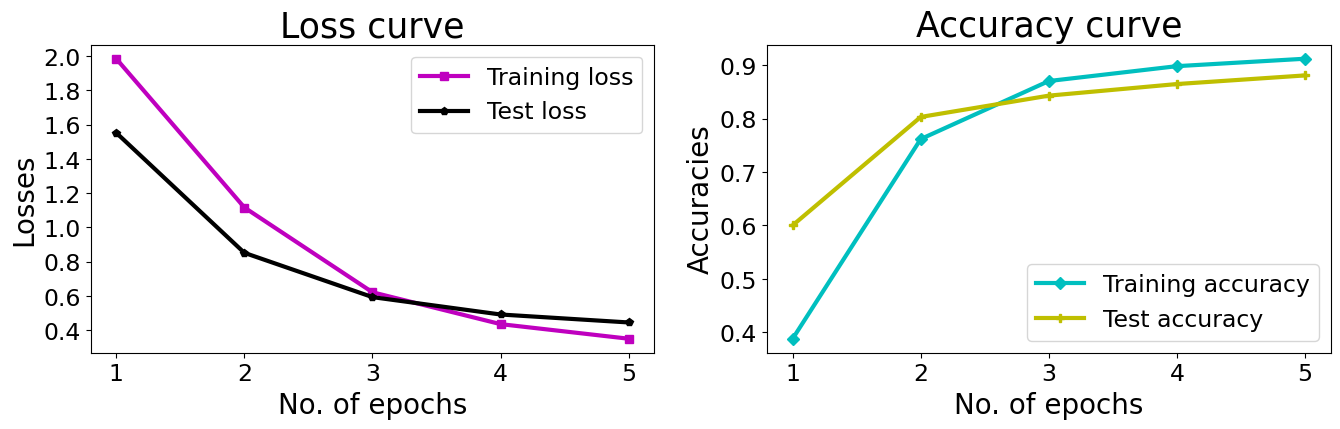

In [17]:
N = [1, 2, 3, 4, 5]

fig = plt.figure(figsize=(16, 4))

fig.add_subplot(1, 2, 1)
plt.plot(N, training_loss, 'm-s', linewidth=3, label='Training loss')
plt.plot(N, test_loss, 'k-p', linewidth=3, label='Test loss')
plt.title('Loss curve', fontsize=25)
plt.xlabel('No. of epochs', fontsize=20)
plt.ylabel('Losses', fontsize=20)
plt.xticks([1, 2, 3, 4, 5], fontsize=17)
plt.yticks(fontsize=17)
plt.legend(fontsize=17)

fig.add_subplot(1, 2, 2)
plt.plot(N, training_accuracy, 'c-D', linewidth=3, label='Training accuracy')
plt.plot(N, test_accuracy, 'y-P', linewidth=3, label='Test accuracy')
plt.title('Accuracy curve', fontsize=25)
plt.xlabel('No. of epochs', fontsize=20)
plt.ylabel('Accuracies', fontsize=20)
plt.xticks([1, 2, 3, 4, 5], fontsize=17)
plt.yticks(fontsize=17)
plt.legend(fontsize=17);

## 13. Model prediction

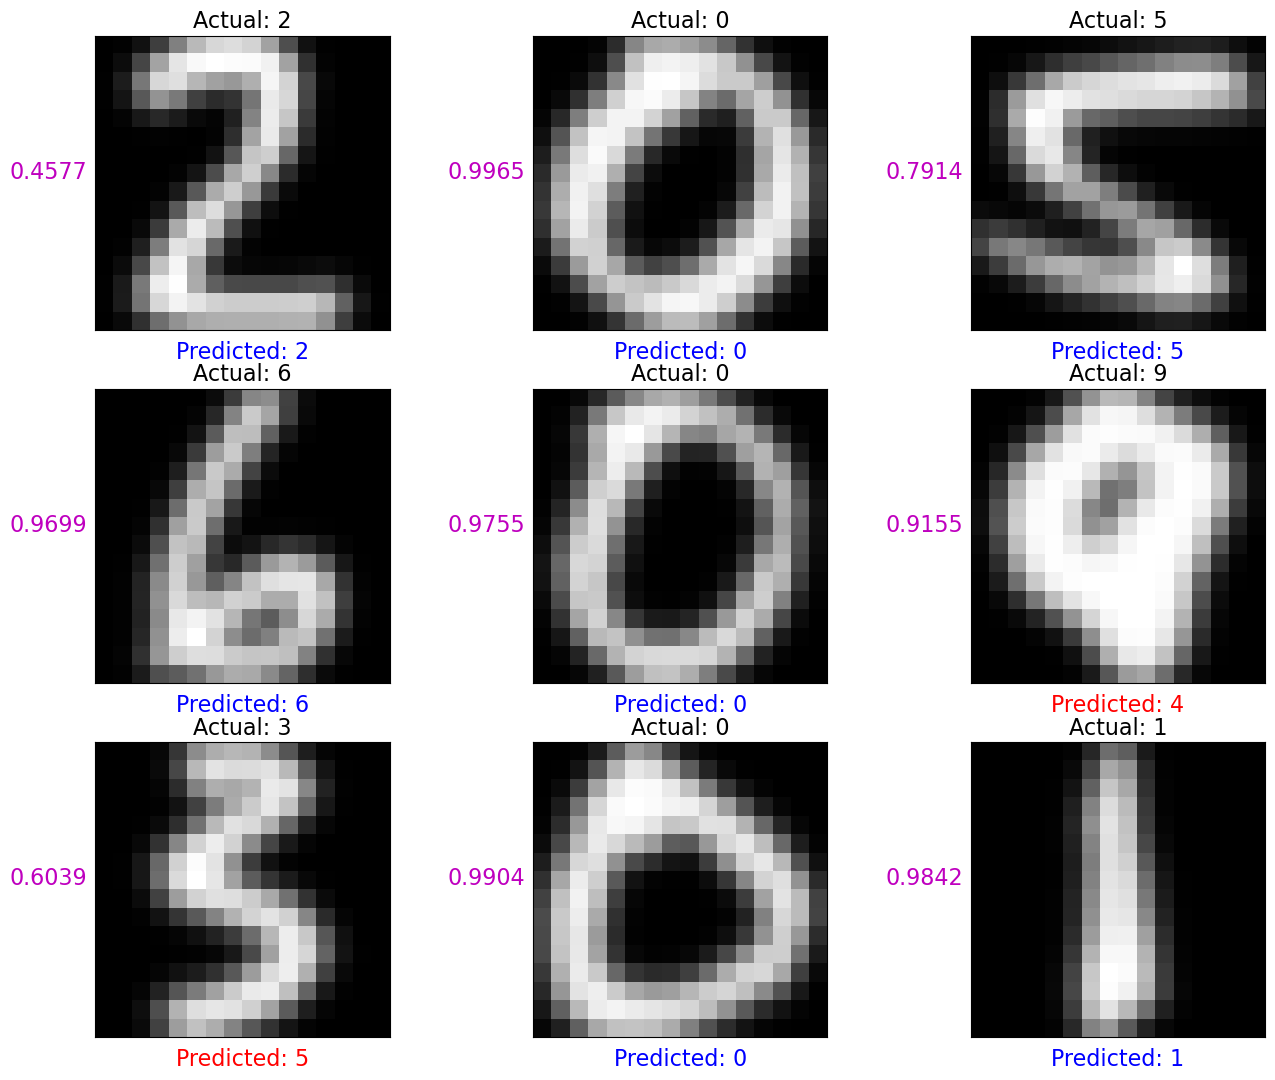

In [18]:
SAMPLES, PREDS, LABELS = [], [], []

for a in range(9):
    idx = np.random.randint(len(test_dataset))
    SAMPLES.append(test_dataset[idx])
    output = F.softmax(ann.cpu()(SAMPLES[a][0].unsqueeze(0)), dim=-1)
    pred_values, pred_labels = output.max(-1)
    PREDS.append(round(float(pred_values), 4))
    LABELS.append(int(pred_labels))

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(16, 13))
i = 0
for R in range(3):
    for C in range(3):
        ax[R, C].imshow(torch.clamp(SAMPLES[i][0], min=0, max=1).permute(1, 2, 0), cmap='gray')
        ax[R, C].set_title('Actual: ' + str(SAMPLES[i][1]), fontsize=16).set_color('k') # actual labels
        if SAMPLES[i][1] == LABELS[i]:
            ax[R, C].set_xlabel('Predicted: ' + str(LABELS[i]), fontsize=16).set_color('b') # correctly predicted labels
        else:
            ax[R, C].set_xlabel('Predicted: ' + str(LABELS[i]), fontsize=16).set_color('r') # wrongly predicted labels
        ax[R, C].set_ylabel(PREDS[i], fontsize=16, rotation=0, labelpad=30).set_color('m') # probability of predicted class
        ax[R, C].set_xticks([])
        ax[R, C].set_yticks([])
        i += 1

We are randomly selecting 9 images from the test set and checking the model prediction on them.